In [113]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.autograd import Variable
from sklearn.preprocessing import normalize
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
from pathlib import Path
!pip install -U finance-datareader
import FinanceDataReader as fdr

In [114]:
df_kospi = fdr.StockListing('KOSPI')

In [115]:
def get_ticker(company_name):
    return str(df_kospi.loc[df_kospi['Name'] == company_name]['Symbol'].values[0])

In [116]:
df_samsung = fdr.DataReader(get_ticker('삼성전자'), '2011-03-01', '2020-02-28')
print(df_samsung.shape)

(2217, 6)


In [117]:
def normalize_close_price(df):
    df = df['Close']
    close_arr = (df.values).reshape(-1, 1)
    normalized_close_arr = (normalize(close_arr, axis=0)).squeeze()
    return normalized_close_arr

In [118]:
arr_samsung = normalize_close_price(df_samsung)
#print(arr_samsung)

In [119]:
def timeseries_for(arr):
    window_size = 20 # Time Window
    time_series = np.float32(np.empty([len(arr) - window_size - 1, window_size + 1]))
    for i in range(len(arr) - window_size - 1):
      time_series[i,:] = arr[i:i + window_size + 1]
    return time_series

In [120]:
time_series_samsung = timeseries_for(arr_samsung)
print(time_series_samsung)

[[0.01114385 0.01120455 0.01147161 ... 0.01111957 0.01111957 0.01124097]
 [0.01120455 0.01147161 0.01099818 ... 0.01111957 0.01124097 0.0113138 ]
 [0.01147161 0.01099818 0.01091321 ... 0.01124097 0.0113138  0.01141092]
 ...
 [0.03568946 0.03587155 0.03471832 ... 0.03593225 0.03447554 0.0351432 ]
 [0.03587155 0.03471832 0.03423275 ... 0.03447554 0.0351432  0.03429345]
 [0.03471832 0.03423275 0.03471832 ... 0.0351432  0.03429345 0.03392927]]


In [121]:
X = time_series_samsung[:, 0:20]
Y = time_series_samsung[:, 20]
print(X.shape, Y.shape)

(2196, 20) (2196,)


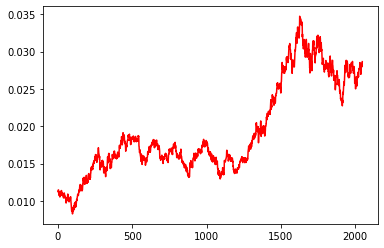

In [122]:
trainset_size = 2048
X = time_series_samsung[:trainset_size, 0:20]
Y = time_series_samsung[:trainset_size, 20]
plt.plot(np.arange(0.0, trainset_size, 1.0), Y, 'r-')
plt.draw()

In [123]:
from easydict import EasyDict as edict

args = edict()
args.batch_size = 64
args.nlayers = 2
args.nhid = 20

device = 'cuda:0' if torch.cuda.is_available() and args.gpu else 'cpu'

In [124]:
class StockDataset(Dataset):
    def __init__(self, X_dataset, Y_dataset):
        self.X_dataset = torch.from_numpy(X_dataset).unsqueeze(2).transpose(0, 1)
        self.Y_dataset = torch.from_numpy(Y_dataset)        
    def __len__(self):
        return np.shape(self.Y_dataset)[0]
    def __getitem__(self, idx):        
        sample = {'Sequence': self.X_dataset[:,idx,:], 'Target': self.Y_dataset[idx]}
        return sample

In [125]:
train_dataset = StockDataset(X, Y)
train_dl = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=False, num_workers=4)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [126]:
class PredictorLSTM(nn.Module):
    def __init__(self):
        super(PredictorLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=args.nhid, num_layers=args.nlayers, batch_first = True)
        self.bn = nn.BatchNorm1d(20)
        self.fc = nn.Linear(20,1)
    def forward(self,x, h_state, c_state):
        r_out, (h_state,c_state) = self.lstm(x, (h_state,c_state))    
        r_out = self.bn(r_out)
        outs=[]
        for time_step in range(r_out.size(1)):
            outs.append(self.fc(r_out[:,time_step,:]))
        return torch.stack(outs,dim=1), (h_state, c_state)

In [127]:
predictor = PredictorLSTM().to(device)
print(predictor)

PredictorLSTM(
  (lstm): LSTM(1, 20, num_layers=2, batch_first=True)
  (bn): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=20, out_features=1, bias=True)
)


In [128]:
criterion = nn.MSELoss()
optimizer = optim.Adam(predictor.parameters(), lr=0.00005)

In [129]:
def run_training(model):
    h_state = torch.zeros(args.nlayers,args.batch_size,args.nhid).to(device)
    c_state = torch.zeros(args.nlayers,args.batch_size,args.nhid).to(device)
    best_loss = float('inf')
    best_epoch = 0
    best_plot = np.empty([trainset_size])
    for epoch in range (100):
        running_loss = 0.0
        prediction_plot=np.empty([trainset_size])
        
        for i, data in enumerate(train_dl):
        # get the inputs
            inputs, labels = data['Sequence'], data['Target']
            x = Variable(inputs).to(device)
            y = Variable(labels).to(device)
            
        # zero the parameter gradients
            optimizer.zero_grad()
            
        # forward + backward + optimize
            prediction, (h_state, c_state) = model(x, h_state, c_state)
            prediction=prediction[:,19,:].squeeze()
            h_state = Variable(h_state.data)
            c_state = Variable(c_state.data)
            loss = criterion(prediction, y)
            loss.backward()
            optimizer.step()
            
        # print statistics
            running_loss += loss.item()
            prediction_plot[i * args.batch_size:(i + 1) * args.batch_size] = prediction.cpu().detach().numpy()
        print('Epoch %d Loss %.7f' %(epoch + 1, running_loss))
    #     if running_loss < best_loss:
    #         best_loss = running_loss
    #         best_epoch = epoch + 1
    #         best_plot = prediction_plot
    # print(f'Best Epoch {best_epoch} with Loss {best_loss}')
    return prediction_plot

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 1 Loss 0.0573211
Epoch 2 Loss 0.0050436
Epoch 3 Loss 0.0013199
Epoch 4 Loss 0.0019843
Epoch 5 Loss 0.0020082
Epoch 6 Loss 0.0021554
Epoch 7 Loss 0.0022890
Epoch 8 Loss 0.0024072
Epoch 9 Loss 0.0025146
Epoch 10 Loss 0.0026105
Epoch 11 Loss 0.0026950
Epoch 12 Loss 0.0027684
Epoch 13 Loss 0.0028314
Epoch 14 Loss 0.0028849
Epoch 15 Loss 0.0029298
Epoch 16 Loss 0.0029670
Epoch 17 Loss 0.0029975
Epoch 18 Loss 0.0030222
Epoch 19 Loss 0.0030420
Epoch 20 Loss 0.0030576
Epoch 21 Loss 0.0030695
Epoch 22 Loss 0.0030784
Epoch 23 Loss 0.0030848
Epoch 24 Loss 0.0030890
Epoch 25 Loss 0.0030915
Epoch 26 Loss 0.0030924
Epoch 27 Loss 0.0030920
Epoch 28 Loss 0.0030906
Epoch 29 Loss 0.0030884
Epoch 30 Loss 0.0030854
Epoch 31 Loss 0.0030817
Epoch 32 Loss 0.0030776
Epoch 33 Loss 0.0030730
Epoch 34 Loss 0.0030681
Epoch 35 Loss 0.0030629
Epoch 36 Loss 0.0030575
Epoch 37 Loss 0.0030518
Epoch 38 Loss 0.0030461
Epoch 39 Loss 0.0030401
Epoch 40 Loss 0.0030341
Epoch 41 Loss 0.0030280
Epoch 42 Loss 0.0030218
E

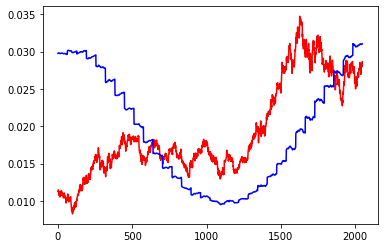

In [130]:
prediction_plot = run_training(predictor)
plt.plot(np.arange(0.0, trainset_size, 1.0), Y, 'r-')
plt.plot(np.arange(0.0, trainset_size, 1.0), np.asarray(prediction_plot), 'b-')
plt.draw()